In [242]:
#Interactuar con el API
import requests
import json
from time import sleep

#procesamiento de datos
import numpy as np
import pandas as pd
import os
import re
from thefuzz import process, fuzz

#Visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

In [243]:
with open('data/comp_publico.csv', mode= 'r', encoding='utf-8') as p:
    df_publico=pd.read_csv(p)

with open('data/comp_critica.csv', mode= 'r', encoding='utf-8') as p:
    df_critica=pd.read_csv(p)

In [244]:
df_publico=df_publico[['Nombre_Secuela', 'developers_Secuela', 'Nun_total_de_reseñas_Secuela', 'pct_pos_total_Secuela', 'Nombre_Base', 'Nombre_Original', 'Fecha_de_lanzamiento_Original',	'developers_Original', 'Nun_total_de_reseñas_Original', 'pct_pos_total_Original', 'Años_de_diferencia']]
df_publico.head()


,Nombre_Secuela,developers_Secuela,Nun_total_de_reseñas_Secuela,pct_pos_total_Secuela,Nombre_Base,Nombre_Original,Fecha_de_lanzamiento_Original,developers_Original,Nun_total_de_reseñas_Original,pct_pos_total_Original,Años_de_diferencia
0,12 Labours of Hercules II: The Cretan Bull,"['Jetdogs Studios', 'Zoom Out Games']",1707,90,12 Labours of Hercules,12 Labours of Hercules,2015-03-23,"['Jetdogs Studios', 'Zoom Out Games']",2276,93,0
1,9-nine-:Episode 2,['PALETTE'],1478,98,9-nine-,9-nine-:Episode 1,2019-01-31,['PALETTE'],1459,95,0
2,9-nine-:Episode 4,['PALETTE'],1086,98,9-nine-,9-nine-:Episode 1,2019-01-31,['PALETTE'],1459,95,2
3,A Plague Tale: Requiem,['Asobo Studio'],15129,91,A Plague Tale,A Plague Tale: Innocence,2019-05-14,['Asobo Studio'],53926,93,3
4,A Total War Saga: TROY,"['CREATIVE ASSEMBLY', 'Feral Interactive (Mac)']",2765,71,A Total War Saga,A Total War Saga: THRONES OF BRITANNIA,2018-05-02,"['CREATIVE ASSEMBLY', 'Feral Interactive (Mac)...",11583,69,3


In [245]:
df_critica.head()

,Unnamed: 0,nombre_franquicia,game_name_s,score_s,publish_date_s,game_name_o,score_o,publish_date_o,diferencia
0,0,007,007: The World is not Enough,7.050,2000-10-27 06:37:58,007: Tomorrow Never Dies,5.7,1999-11-22 02:52:35,1.350
1,1,007,007: NightFire,7.425,2002-11-25 05:46:51,007: Tomorrow Never Dies,5.7,1999-11-22 02:52:35,1.725
2,2,007,007: Quantum of Solace,7.000,2008-11-05 03:29:03,007: Tomorrow Never Dies,5.7,1999-11-22 02:52:35,1.300
3,3,1080,1080: Avalanche,6.700,2003-12-03 03:36:14,1080: TenEighty Snowboarding,8.6,1998-03-25 12:00:00,-1.900
4,4,1942,1942: Joint Strike,6.500,2008-07-28 06:54:42,1942,4.5,2000-06-15 02:10:24,2.000


In [246]:
df_publico.rename(columns={'Nombre_Secuela': 'secuela',	'developers_Secuela': 'dev_s','Nun_total_de_reseñas_Secuela': 'tot_s',
                    'pct_pos_total_Secuela': 'pct_pos_s', 'Nombre_Base': 'franquicia', 'Nombre_Original': 'original',
                    'Fecha_de_lanzamiento_Original': 'lazamiento', 'developers_Original': 'dev_o',
                    'Nun_total_de_reseñas_Original': 'tot_o', 'pct_pos_total_Original': 'pct_pos_o', 'Años_de_diferencia': 'años_dif'}, inplace= True, errors='raise')
sacar = r'\s*(™|®|©)\s*'
df_publico.drop_duplicates(subset='franquicia', inplace=True)
df_publico['franquicia'] = df_publico['franquicia'].str.lower()
df_publico['secuela'] = df_publico['secuela'].str.lower()
df_publico['original'] = df_publico['original'].str.lower()
df_publico['franquicia'] = df_publico['franquicia'].str.replace(sacar, '', regex=True)
df_publico.info()

<class 'pandas.core.frame.DataFrame'>
Index: 434 entries, 0 to 706
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   secuela     434 non-null    object
 1   dev_s       434 non-null    object
 2   tot_s       434 non-null    int64 
 3   pct_pos_s   434 non-null    int64 
 4   franquicia  434 non-null    object
 5   original    434 non-null    object
 6   lazamiento  434 non-null    object
 7   dev_o       434 non-null    object
 8   tot_o       434 non-null    int64 
 9   pct_pos_o   434 non-null    int64 
 10  años_dif    434 non-null    int64 
dtypes: int64(5), object(6)
memory usage: 40.7+ KB


In [247]:
df_critica.rename(columns={'nombre_franquicia': 'franquicia', 'game_name_s': 'secuela', 'score_s': 'puntuacion_s', 'game_name_o': 'original',
                    'score_o': 'puntuacion_o', 'diferencia': 'puntuancion_dif'}, inplace = True)
df_critica.drop_duplicates(subset='franquicia', inplace=True)
sacar = r'\s*(™|®|©)\s*'
df_critica['franquicia'] = df_critica['franquicia'].str.lower()
df_critica['secuela'] = df_critica['secuela'].str.lower()
df_critica['original'] = df_critica['original'].str.lower()
df_critica['franquicia'] = df_critica['franquicia'].str.replace(sacar, '', regex=True)
df_critica.drop(columns= 'Unnamed: 0', inplace=True)
df_critica.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1238 entries, 0 to 3092
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   franquicia       1238 non-null   object 
 1   secuela          1238 non-null   object 
 2   puntuacion_s     1238 non-null   float64
 3   publish_date_s   1238 non-null   object 
 4   original         1238 non-null   object 
 5   puntuacion_o     1238 non-null   float64
 6   publish_date_o   1238 non-null   object 
 7   puntuancion_dif  1238 non-null   float64
dtypes: float64(3), object(5)
memory usage: 87.0+ KB


In [248]:
unionf = set(df_critica['franquicia']) & set(df_publico['franquicia'])
print(len(unionf))

unions = set(df_critica['original']) & set(df_publico['secuela'])
print(unions)

163
{'danganronpa 2: goodbye despair', 'everquest', 'dungeon siege', 'red dead redemption', 'bloodstained: ritual of the night'}


In [249]:
df_critica['orden']=df_critica.groupby('franquicia').cumcount()
df_publico['orden']=df_publico.groupby('franquicia').cumcount()
df_union= df_publico.merge(df_critica[['franquicia','puntuacion_s', 'publish_date_s', 'puntuacion_o', 'publish_date_o', 'puntuancion_dif', 'orden']], how='inner', on=['franquicia','orden'])
df_union.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   secuela          163 non-null    object 
 1   dev_s            163 non-null    object 
 2   tot_s            163 non-null    int64  
 3   pct_pos_s        163 non-null    int64  
 4   franquicia       163 non-null    object 
 5   original         163 non-null    object 
 6   lazamiento       163 non-null    object 
 7   dev_o            163 non-null    object 
 8   tot_o            163 non-null    int64  
 9   pct_pos_o        163 non-null    int64  
 10  años_dif         163 non-null    int64  
 11  orden            163 non-null    int64  
 12  puntuacion_s     163 non-null    float64
 13  publish_date_s   163 non-null    object 
 14  puntuacion_o     163 non-null    float64
 15  publish_date_o   163 non-null    object 
 16  puntuancion_dif  163 non-null    float64
dtypes: float64(3), i

In [250]:
df_union.head()

,secuela,dev_s,tot_s,pct_pos_s,franquicia,original,lazamiento,dev_o,tot_o,pct_pos_o,años_dif,orden,puntuacion_s,publish_date_s,puntuacion_o,publish_date_o,puntuancion_dif
0,a plague tale: requiem,['Asobo Studio'],15129,91,a plague tale,a plague tale: innocence,2019-05-14,['Asobo Studio'],53926,93,3,0,7.0,2022-10-17 11:00:00,8.000000,2019-05-13 04:00:00,-1.000000
1,age of empires: definitive edition,"['Forgotten Empires', 'Tantalus']",12610,83,age of empires,age of empires ii (retired),2013-04-09,"['Skybox Labs', 'Hidden Path Entertainment', '...",83103,95,6,0,7.7,1999-10-12 12:00:00,6.733333,1997-10-27 12:49:08,0.966667
2,age of wonders: planetfall,['Triumph Studios'],4547,80,age of wonders,age of wonders iii,2014-03-31,['Triumph Studios'],6878,81,5,0,8.8,2002-06-17 04:56:04,8.600000,1999-12-06 12:00:00,0.200000
3,aliens: dark descent,['Tindalos Interactive'],12418,88,aliens,aliens: fireteam elite,2021-08-23,['Cold Iron Studios'],18965,81,2,0,8.0,2011-11-17 06:09:22,5.000000,2004-01-01 12:00:00,3.000000
4,amnesia: a machine for pigs,['The Chinese Room'],6602,68,amnesia,amnesia: the dark descent,2010-09-08,['Frictional Games'],18867,95,3,0,8.0,2013-09-09 06:00:00,8.500000,2010-09-30 05:57:28,-0.500000


In [251]:
df_union['pct_dif']=df_union['pct_pos_s']-df_union['pct_pos_o']
df_union['devs_continuacion']= df_union['dev_s']==df_union['dev_o']
df_union['publish_date_o'] = pd.to_datetime(df_union['publish_date_o']).dt.year


In [254]:
df_datos=df_union.drop(columns=['secuela',	'dev_s',	'franquicia',	'original',	'lazamiento',	'dev_o', 'publish_date_s', 'orden'])

<Axes: >

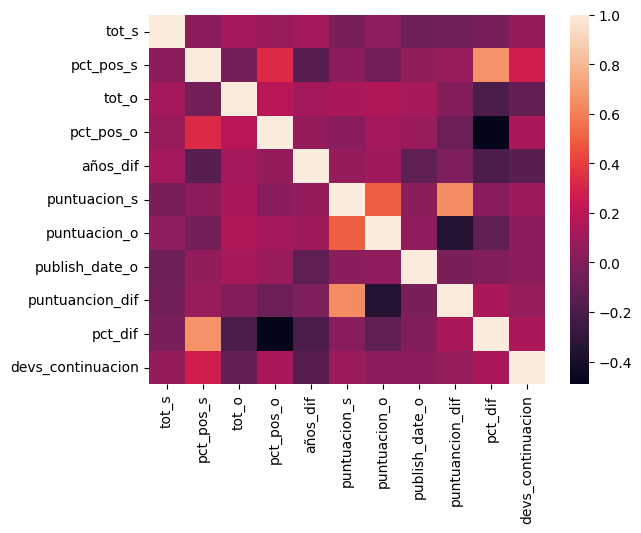

In [255]:
corr=df_datos.corr()

sns.heatmap(corr)

Notemos que los unicos datos que tienen alguna relación son codependientes

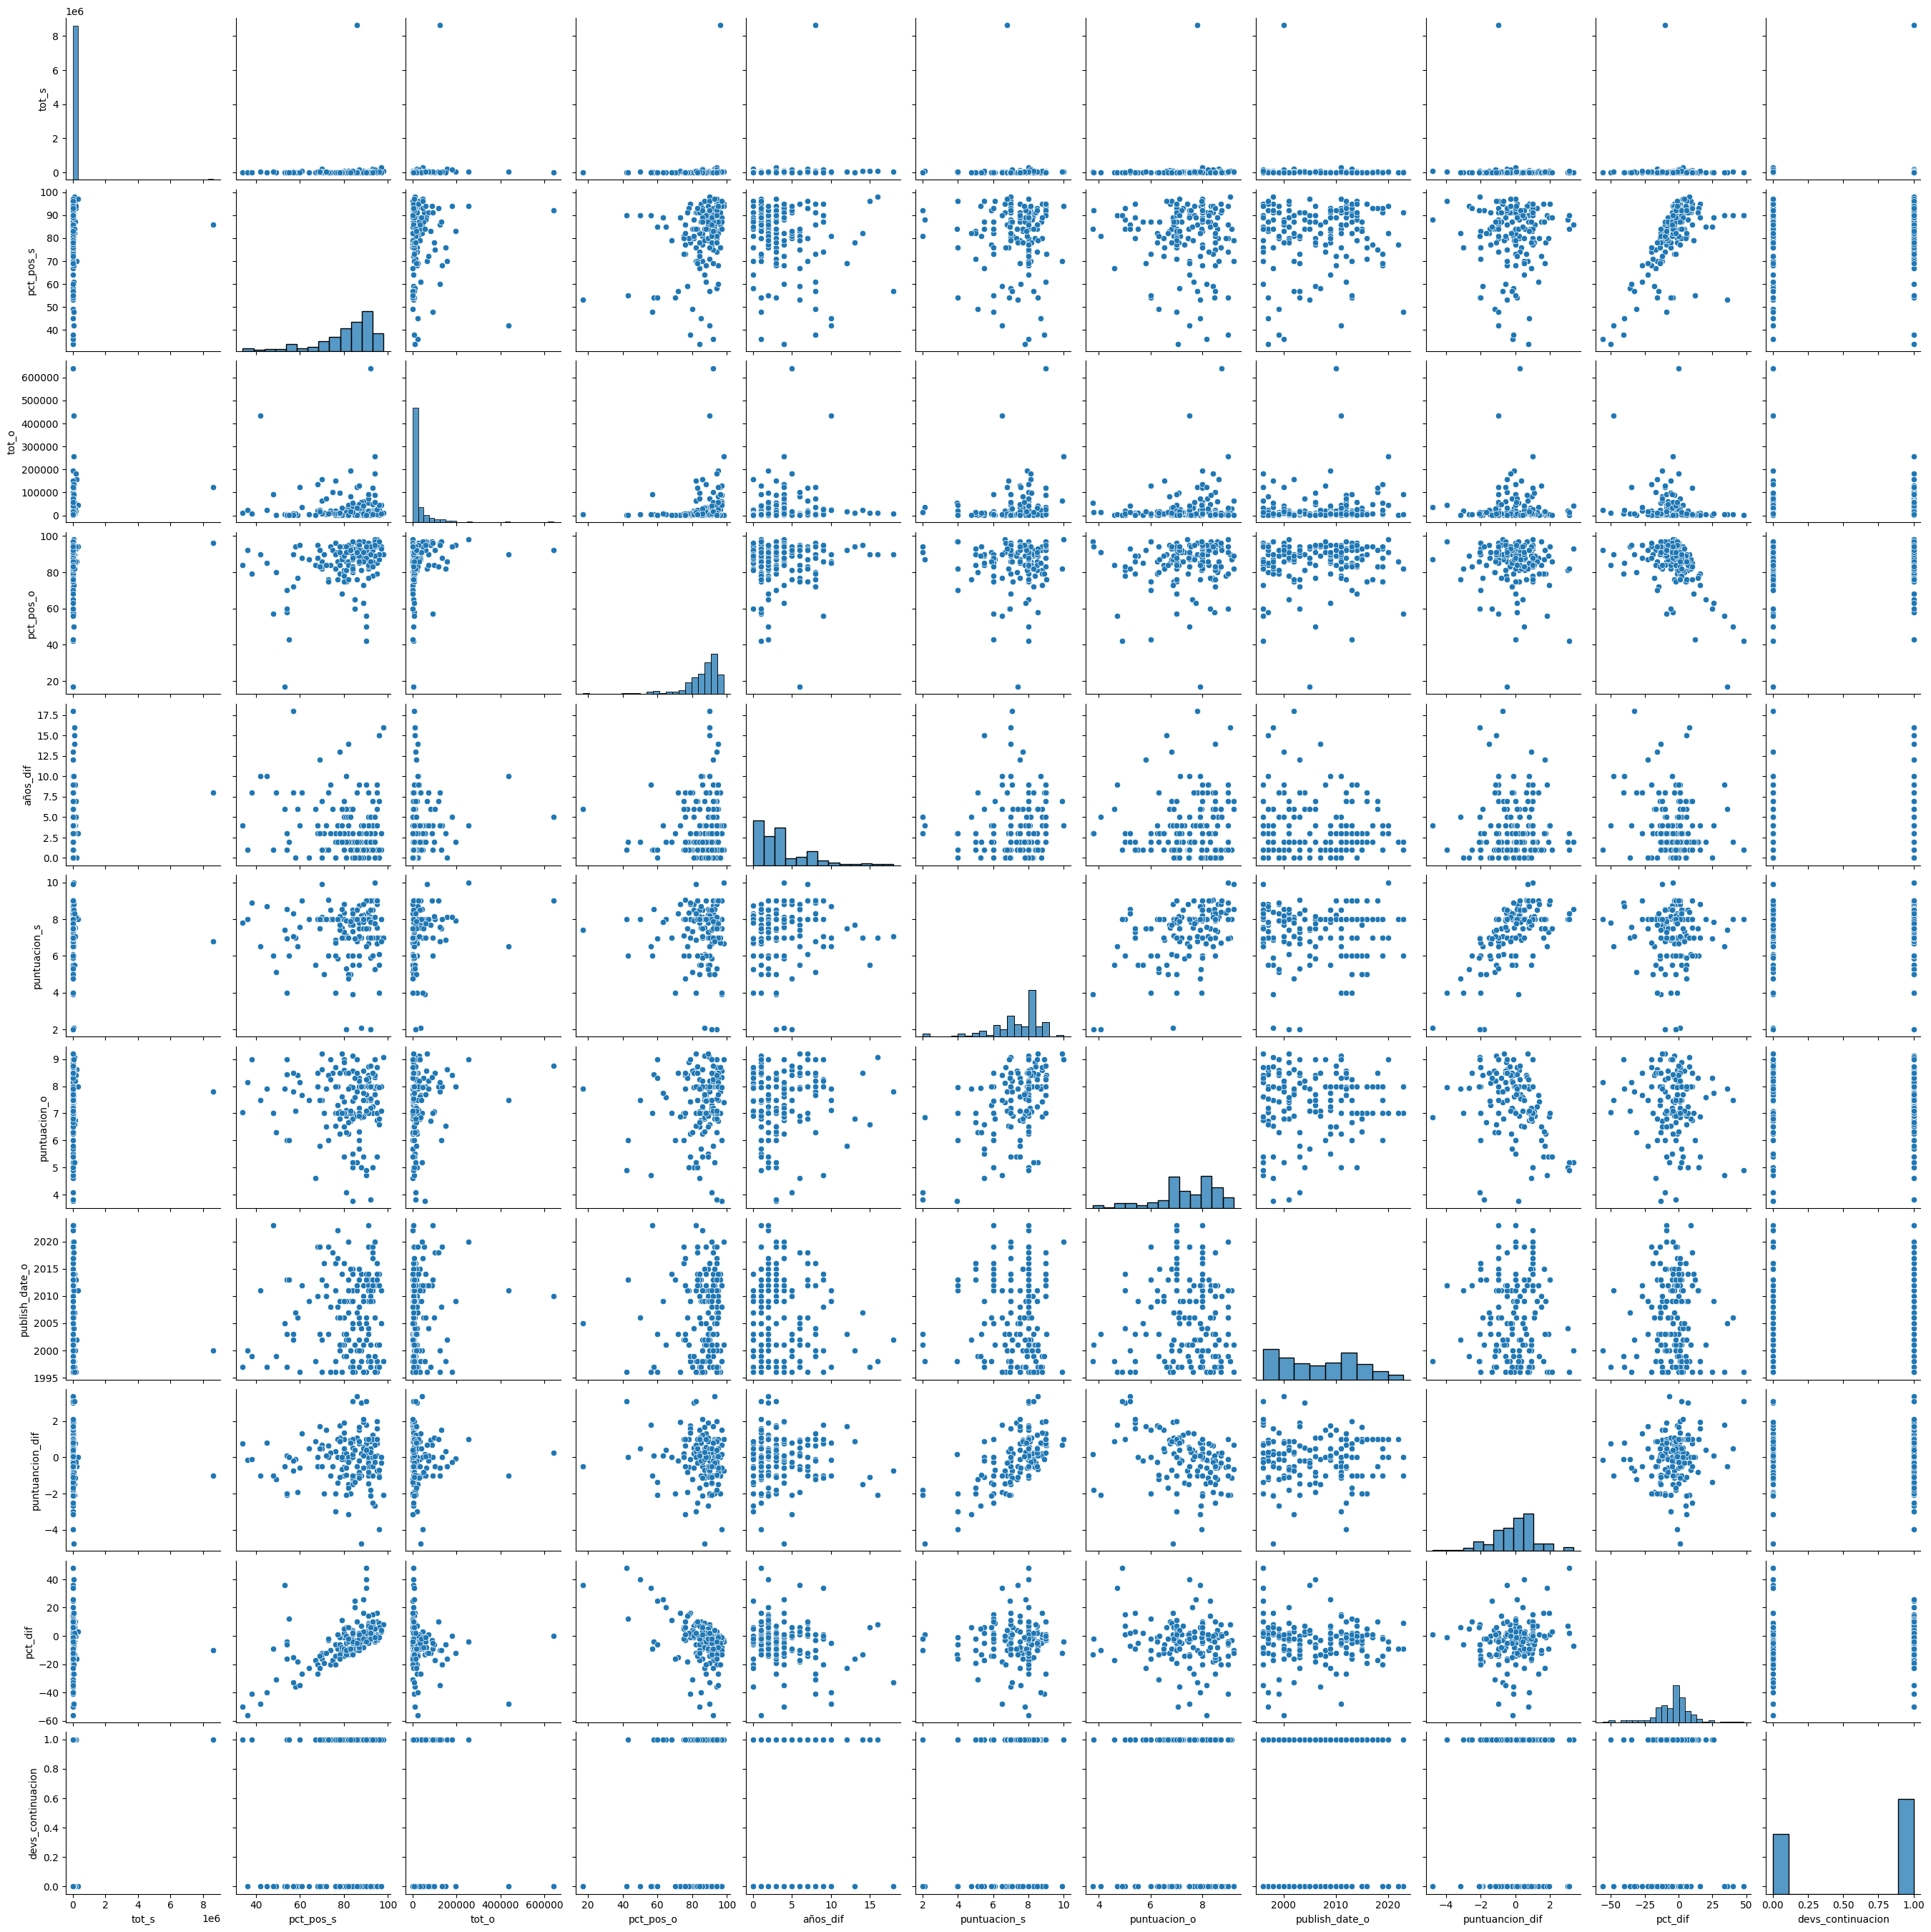

In [256]:
sns.pairplot(df_datos)